<a href="https://colab.research.google.com/github/OGsiji/Covid-19-tweets-text-classification/blob/main/Covid_19_tweets_EDA_Machine_Learning_and_Deep_Learning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 1. Introduction<a name="introduction"></a>
# This is my solution to the test classification question, With this notebook, I will classify these tweets using Support Vectors Classifier, Logistic Regression and Recurrent Neural Networks. I will start with some data cleaning and perform visualizations and statistical analysis on the data, showing the intrinsic statistical properties of the key features of the data set and then discuss my insights from the dataset.

In [13]:
!pip install chart_studio

In [14]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import string
import requests
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, plot, iplot

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
from os import path

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "drive/My Drive/"

Mounted at /content/drive/
/content/drive/My Drive


In [18]:
data_dict = {}
for dirname, _, filenames in os.walk('Corona'):
    for filename in filenames:
        data_dict[filename] = os.path.join(dirname,filename)
        print(os.path.join(dirname, filename))
print(data_dict)

Corona/Corona_NLP_train.csv
Corona/Corona_NLP_test.csv
Corona/corona.jpeg
{'Corona_NLP_train.csv': 'Corona/Corona_NLP_train.csv', 'Corona_NLP_test.csv': 'Corona/Corona_NLP_test.csv', 'corona.jpeg': 'Corona/corona.jpeg'}


In [19]:
# Load in training data
train = pd.read_csv(data_dict['Corona_NLP_train.csv'], encoding = 'latin1')
# Copy training data
df = train.copy()
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [20]:
# Load in test data
test_df = pd.read_csv(data_dict['Corona_NLP_test.csv'], encoding = 'latin1')
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


# 2. Data Cleaning <a name="data_cleaning"></a>

In [21]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [22]:
# Replace na with 'None'
df['Location'].fillna('None', inplace = True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [23]:
# Join stopwords together and set them for use in cleaning function.
", ".join(stopwords.words('english'))
stops = set(stopwords.words('english'))

# Function that cleans tweets for classification. 
def clean_tweet(tweet):
    # Remove hyperlinks.
    tweet= re.sub(r'https?://\S+|www\.\S+','',tweet)
    # Remove html
    tweet = re.sub(r'<.*?>','',tweet)
    # Remove numbers (Do we want to remove numbers? Death toll?)
    tweet = re.sub(r'\d+','',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+','',tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s\d]','',tweet)
    # Remove whitespace
    tweet = re.sub(r'\s+',' ',tweet).strip()
    # Remove stopwords
    tweet = " ".join([word for word in str(tweet).split() if word not in stops])
    
    return tweet.lower()

In [24]:
# Check function
example2 = df['OriginalTweet'][1]
clean_tweet(example2)

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [25]:
# Apply text cleaning function to training and test dataframes.
df['newTweet'] = df['OriginalTweet'].apply(lambda x: clean_tweet(x))
test_df['newTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_tweet(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...


### Here, I defined a couple functions to either stem or lemmatize the tweets. These methods will be compared during classification to see which one gives us the model with the greatest accuracy. 

In [26]:
def token_stem(tweet):
    tk = TweetTokenizer()
    stemmer = PorterStemmer()
    tweet = tk.tokenize(tweet)
    tweet = [stemmer.stem(word) for word in tweet]
    tweet =  tweet = " ".join([word for word in tweet])
    return tweet

In [27]:
def token_lemma(tweet):
    tk = TweetTokenizer()
    lemma = WordNetLemmatizer()
    tweet = tk.tokenize(tweet)
    tweet = [lemma.lemmatize(word) for word in tweet]
    tweet = " ".join([word for word in tweet])
    return tweet

In [28]:
tweet = df['newTweet'][1]
tweet

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [29]:
print(token_stem(tweet))
print('\n')
print(token_lemma(tweet))

advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist gp set onlin shop account poss adequ suppli regular med order


advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order


### See the differences in these techniques? Stemming converts words to their 'stems', while lemmatizing brings the words to their 'lemmas', or dictionary forms. 

In [30]:
df['stemTweet'] = df['newTweet'].apply(lambda x: token_stem(x))
df['lemmaTweet'] = df['newTweet'].apply(lambda x: token_lemma(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...


In [31]:
# Create more useful labels for classification.
# We will take the original 5 possibilites and
# reduce them to 3, removing the "extremelys".
def make_label(sentiment):
    
    label = ''
    if 'Positive' in sentiment: 
        label = 1
    if 'Negative' in sentiment:
        label = -1
    if 'Neutral' in sentiment:
        label = 0
    return label

In [32]:
# Apply make_label funtion to training and test dataframes.
df['label'] = df['Sentiment'].apply(lambda x: make_label(x))
test_df['label'] = test_df['Sentiment'].apply(lambda x: make_label(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1


### Below are some of the common locations found in the tweets that will help us properly map more tweets to a particular country.

In [33]:
# Some frequent US locations
us_filters = ('New York', 'New York, NY', 'NYC', 'NY', 'Washington, DC', 'Los Angeles, CA',
             'Seattle, Washington', 'Chicago', 'Chicago, IL', 'California, USA', 'Atlanta, GA',
             'San Francisco, CA', 'Boston, MA', 'New York, USA', 'Texas, USA', 'Austin, TX',
              'Houston, TX', 'New York City', 'Philadelphia, PA', 'Florida, USA', 'Seattle, WA',
             'Washington, D.C.', 'San Diego, CA', 'Las Vegas, NV', 'Dallas, TX', 'Denver, CO',
             'New Jersey, USA', 'Brooklyn, NY', 'California', 'Michigan, USA', 'Minneapolis, MN',
             'Virginia, USA', 'Miami, FL', 'Texas', 'Los Angeles', 'United States', 'San Francisco',
             'Indianapolis, IN', 'Pennsylvania, USA', 'Phoenix, AZ', 'New Jersey', 'Baltimore, MD',
             'CA', 'FL', 'DC', 'TX', 'IL', 'MA', 'PA', 'GA', 'NC', 'NJ', 'WA', 'VA', 'PAK', 'MI', 'OH',
             'CO', 'AZ', 'D.C.', 'WI', 'MD', 'MO', 'TN', 'Florida', 'IN', 'NV', 'MN', 'OR','LA', 'Michigan',
             'CT', 'SC', 'OK', 'Illinois', 'Ohio', 'UT', 'KY', 'Arizona', 'Colorado')

# Various nation's frequent locations
uk_filters = ('England', 'London', 'london', 'United Kingdom', 'united kingdom',
              'England, United Kingdom', 'London, UK', 'London, England',
              'Manchester, England', 'Scotland, UK', 'Scotland', 'Scotland, United Kingdom',
              'Birmingham, England', 'UK', 'Wales')
india_filters = ('New Delhi, India', 'Mumbai', 'Mumbai, India', 'New Delhi', 'India', 
                 'Bengaluru, India')
australia_filters = ('Sydney, Australia', 'New South Wales', 'Melbourne, Australia', 'Sydney',
                     'Sydney, New South Wales', 'Melbourne, Victoria', 'Melbourne', 'Australia')
canada_filters = ('Toronto, Ontario', 'Toronto', 'Ontario, Canada', 'Toronto, Canada', 'Canada',
                  'Vancouver, British Columbia', 'Ontario', 'Victoria', 'British Columbia', 'Alberta',)
south_africa_filters = ('Johannesburg, South Africa', 'Cape Town, South Africa', 'South Africa')
nigeria_filters = ('Lagos, Nigeria')
kenya_filters = ('Nairobi, Kenya')
france_filters = ('Paris, France')
ireland_filters = ('Ireland')
new_zealand_filters = ('New Zealand')
pakistan_filters = ('Pakistan')
malaysia_filters = ('Malaysia')
uganda_filters = ('Kampala, Uganda', 'Uganda')
singapore_filters = ('Singapore')
germany_filters = ('Germany', 'Deutschland')
switz_filters = ('Switzerland')
uae_filters = ('United Arab Emirates', 'Dubai')
spain_filters = ('Spain')
belg_filters = ('Belgium')
phil_filters = ('Philippines')
hk_filters = ('Hong Kong')
ghana_filters = ('Ghana')
# These all have large counts. Need to be removed from rest of data
other_filters = ('None', 'Worldwide', 'Global', 'Earth', '??')

In [34]:
df['country'] = df['Location'].apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)

In [35]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label,country
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0,London
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1,UK
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1,Vagabonds
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1,None
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1,None


In [36]:
# Changing strings found with filters into 3 digit codes
df['country'] = df['country'].apply(lambda x: 'USA' if x in us_filters else x)
df['country'] = df['country'].apply(lambda x: 'GBR' if x in uk_filters else x)
df['country'] = df['country'].apply(lambda x: 'IND' if x in india_filters else x)
df['country'] = df['country'].apply(lambda x: 'AUS' if x in australia_filters else x)
df['country'] = df['country'].apply(lambda x: 'CAN' if x in canada_filters else x)
df['country'] = df['country'].apply(lambda x: 'ZAF' if x in south_africa_filters else x)
df['country'] = df['country'].apply(lambda x: 'KEN' if x in kenya_filters else x)
df['country'] = df['country'].apply(lambda x: 'NGA' if x in nigeria_filters else x)
df['country'] = df['country'].apply(lambda x: 'SGP' if x in singapore_filters else x)
df['country'] = df['country'].apply(lambda x: 'FRA' if x in france_filters else x)
df['country'] = df['country'].apply(lambda x: 'NZL' if x in new_zealand_filters else x)
df['country'] = df['country'].apply(lambda x: 'PAK' if x in pakistan_filters else x)
df['country'] = df['country'].apply(lambda x: 'MYS' if x in malaysia_filters else x)
df['country'] = df['country'].apply(lambda x: 'IRL' if x in ireland_filters else x)
df['country'] = df['country'].apply(lambda x: 'UGA' if x in uganda_filters else x)
df['country'] = df['country'].apply(lambda x: 'DEU' if x in germany_filters else x)
df['country'] = df['country'].apply(lambda x: 'CHE' if x in switz_filters else x)
df['country'] = df['country'].apply(lambda x: 'ARE' if x in uae_filters else x)
df['country'] = df['country'].apply(lambda x: 'ESP' if x in spain_filters else x)
df['country'] = df['country'].apply(lambda x: 'BEL' if x in belg_filters else x)
df['country'] = df['country'].apply(lambda x: 'PHL' if x in phil_filters else x)
df['country'] = df['country'].apply(lambda x: 'GHA' if x in ghana_filters else x)
df['country'] = df['country'].apply(lambda x: 'HKG' if x in hk_filters else x)
df['country'] = df['country'].apply(lambda x: 'None' if x in other_filters else x)

In [37]:
df['country'].value_counts()

USA             9675
None            8980
GBR             3811
CAN             1233
IND             1097
                ... 
KCMO               1
Floating           1
KSA                1
D-Town             1
RhÃ´ne-Alpes       1
Name: country, Length: 7313, dtype: int64

# 3. Vizualizations <a name="viz"></a>

In [38]:
# 0:30 because that's where the labeled countries end
places_df = pd.DataFrame(df['country'].value_counts()[0:30])
places_df.reset_index(inplace = True)
places_df.rename(columns = {'index':'Country', 'country':'Tweets'}, inplace = True)
# Remove 'None' location
places_df = places_df[places_df['Country'] != 'None']

In [39]:
data = dict(type='choropleth',
            colorscale = 'inferno',
            locations = places_df['Country'],
            z = places_df['Tweets'],
            #locationmode = 'USA-states',
            text = places_df['Tweets'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Number of Tweets"}
            ) 

layout = dict(title = 'Number of Tweets By Country',
              geo = dict(#scope='usa',
                         showlakes = False,
                         lakecolor = 'rgb(85,173,240)',
                         projection_type='equirectangular')
             )

choromap = go.Figure(data = [data],layout = layout)

In [40]:
iplot(choromap)

### The vast majority of tweets come from English speaking countries, which makes sense, since these tweets are all in English. Largest contributer is the USA followed by the UK and Canada.  


In [41]:
# image courtesy of https://www.cdc.gov/media/subtopic/images.html
img = Image.open(data_dict['corona.jpeg'])
mask = np.array(Image.open(data_dict['corona.jpeg']))

# Positive WordCloud
pos_df = df[df['label'] == 1]
pos_text = pos_df['newTweet'].to_string(index = False)
pos_text = re.sub(r'\n','',pos_text)
pos_cloud = WordCloud(colormap = 'Greens', mask = mask).generate(pos_text)

# Neutral WordCloud
neut_df = df[df['label'] == 0]
neut_text = neut_df['newTweet'].to_string(index = False)
neut_text = re.sub(r'\n','', neut_text)
neut_cloud = WordCloud(colormap = 'Blues', mask = mask).generate(neut_text)

# Negative wordcloud
neg_df = df[df['label'] == -1]
neg_text = neg_df['newTweet'].to_string(index = False)
neg_text = re.sub(r'\n','', neg_text)
neg_cloud = WordCloud(colormap = 'Reds', mask = mask).generate(neg_text)

(-0.5, 253.5, 197.5, -0.5)

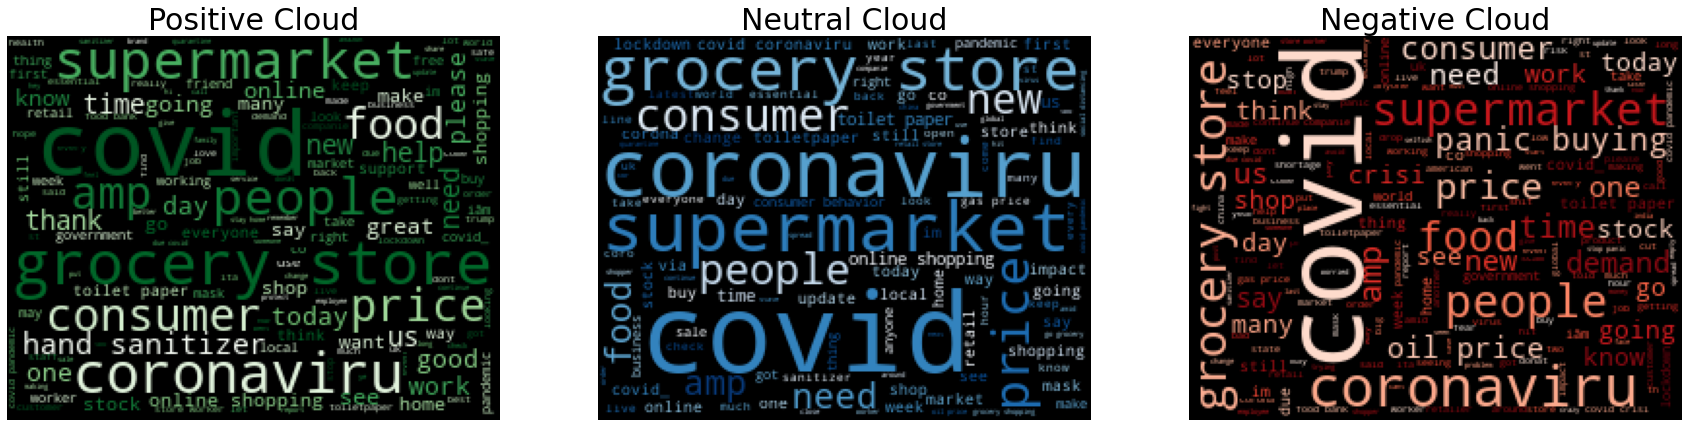

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [30,20])
ax1.imshow(pos_cloud)
ax1.set_title('Positive Cloud', fontsize = 30)
ax1.axis('off')
ax2.imshow(neut_cloud)
ax2.set_title('Neutral Cloud', fontsize = 30)
ax2.axis('off')
ax3.imshow(neg_cloud)
ax3.set_title('Negative Cloud', fontsize = 30)
ax3.axis('off')

### I used an image of the coronavirus for the mask, it certainly could have turned out better...
### 'Grocery store', 'price', 'supermarket', and 'online shopping' being frequent in positive, neutral, and negative tweets is interesting.  Some stand-out negative terms are 'panic buying' and 'toilet paper'. For positive, 'hand sanitizer' catches my attention. 

In [43]:
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

In [44]:
unigram_df = ngram_df(df['newTweet'],(1,1),20)
bigram_df = ngram_df(df['newTweet'],(2,2),20)
trigram_df = ngram_df(df['newTweet'],(3,3),20)

In [45]:
unigram_df['text'][::-1]

19           time
18           like
17      sanitizer
16          panic
15        workers
14           need
13       pandemic
12         covid_
11         online
10       shopping
9        consumer
8             amp
7          people
6         grocery
5           store
4     supermarket
3            food
2          prices
1     coronavirus
0           covid
Name: text, dtype: object

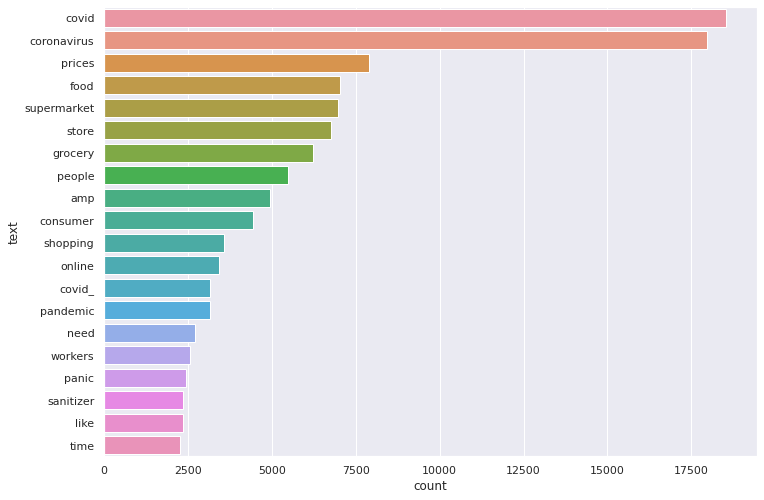

In [46]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = unigram_df, y = 'text', x = 'count')

### 'Prices' being the most frequent unigram after covid/coronavirus may be due to rising food prices and other various shortages.

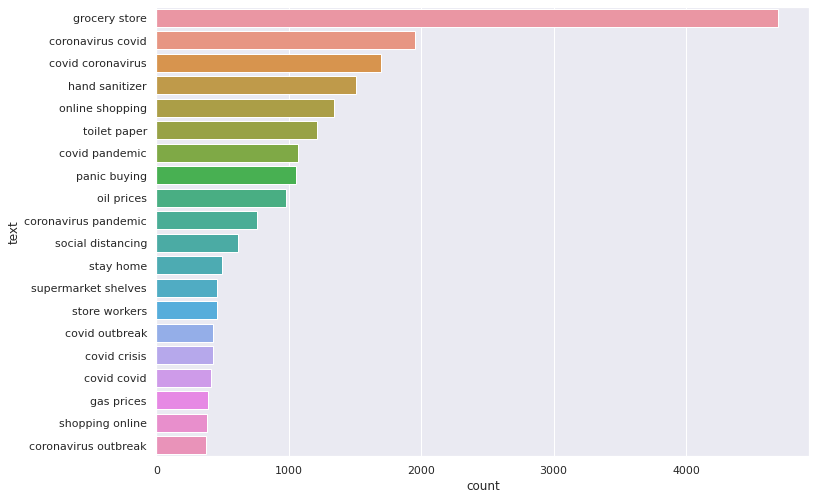

In [47]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = bigram_df, y = 'text', x = 'count')

### Grocery store way outpacing covid bigrams is pretty interesting. Online shopping, hand sanitizer, toilet paper, and panic buying are all within the realm of expectation. 

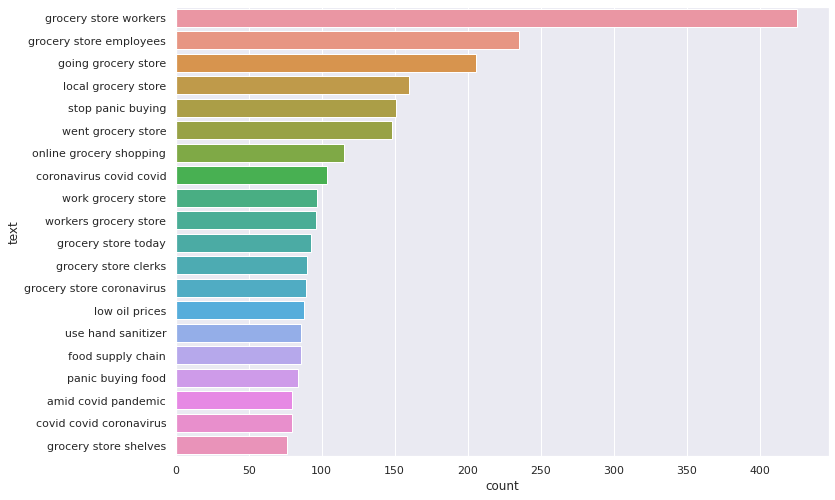

In [48]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = trigram_df, y = 'text', x = 'count')

### Grocery store dominates these trigrams. People may be concerned about the safety of grocery shopping during a pandemic, and the health of the grocery store workers. 

# 4. Classification <a name="classification"></a>

In [49]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
X[1]

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

### I tried 4 different classifiers here: SVC, Logisitic Regression. Furthermore, I also tested whether these models perform better using Term Frequency Inverse Document Frequency or just a simple Count for the vectors we feed into the model. TFIDF increases every time a word appears in a document(tweet), but is then offset for every document(tweet) that word appears. This can help pick out the more important words for classification. Additionally, I used cross validation to help gauge each model's accuracy and variance across multiple splits of the data. 

In [51]:
clf = dict({'SVC': LinearSVC(max_iter = 5000),
            'Logisitc': LogisticRegression(max_iter = 5000)})


In [52]:
def make_models(clf, vectorizer, X_train, y_train, cv = 5):
    
    acc_df = pd.DataFrame(index=range(cv * len(clf)))
    results = []
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                   ('clf', clf[classifier])])
        model.fit(X_train, y_train)
        scores = cross_val_score(model, X_train , y_train, cv = cv)
        model_name = classifier
        for fold, score in enumerate(scores):
            results.append((model_name, fold, score))
    
    acc_df = pd.DataFrame(results, columns=['model_name', 'fold', 'accuracy'])
    
    return acc_df

In [53]:
# Number of folds for K-fold cross validation
cv = 10

In [54]:
tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)
tfidf_df['vectorizer'] = 'tfidf'
count_df['vectorizer'] = 'count'
combined_df = tfidf_df.append(count_df)
combined_df['method'] = 'none'
combined_df.head(10)

,model_name,fold,accuracy,vectorizer,method
0,SVC,0,0.804434,tfidf,none
1,SVC,1,0.800790,tfidf,none
2,SVC,2,0.798056,tfidf,none
3,SVC,3,0.803219,tfidf,none
4,SVC,4,0.801093,tfidf,none
5,SVC,5,0.790401,tfidf,none
6,SVC,6,0.805893,tfidf,none
7,SVC,7,0.804678,tfidf,none
8,SVC,8,0.800122,tfidf,none
9,SVC,9,0.813791,tfidf,none


In [55]:
# Set X and y.
X = df['stemTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

stem_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
stem_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

stem_tfidf_df['method'] = 'stem'
stem_tfidf_df['vectorizer'] = 'tfidf'
stem_count_df['method'] = 'stem'
stem_count_df['vectorizer'] = 'count'
stem_df = stem_tfidf_df.append(stem_count_df)

In [56]:
# Set X and y.
X = df['lemmaTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lemma_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
lemma_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

lemma_tfidf_df['vectorizer'] = 'tfidf'
lemma_tfidf_df['method'] = 'lemma'
lemma_count_df['vectorizer'] = 'count'
lemma_count_df['method'] = 'lemma'
lemma_df = lemma_tfidf_df.append(lemma_count_df)

In [57]:
all_df = lemma_df.append(stem_df)
all_df = all_df.append(combined_df)

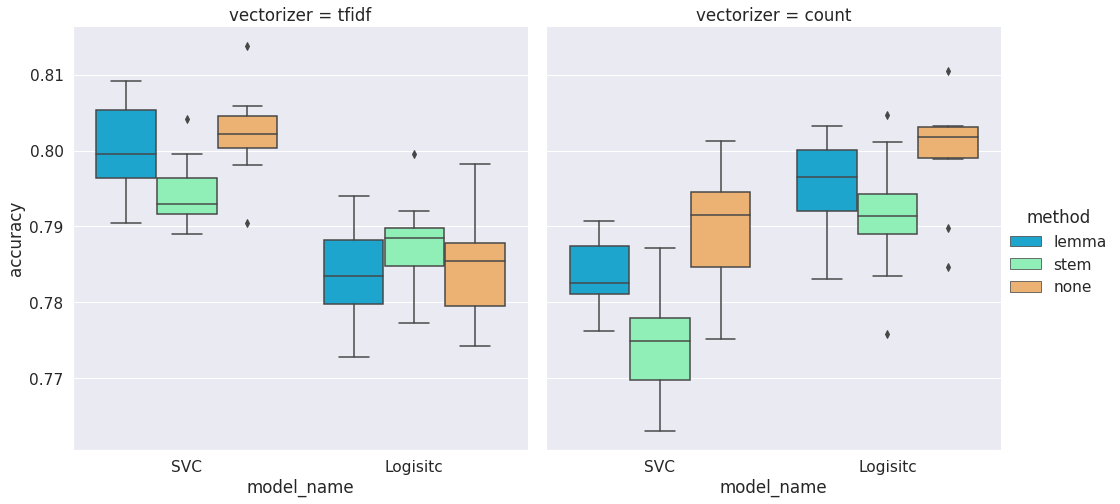

In [60]:

sns.set(font_scale = 1.4)
sns.catplot(x = 'model_name', y = 'accuracy', hue = 'method', height = 7,
            data = all_df, kind = 'box', col = 'vectorizer', palette = 'rainbow')

### SVC does better when using tfidf, and Logistic Regression does better when using count. Stemming seems to do worse than lemmatization accuracy wise, although lemmatization has more outliers. The best results tend to come from using neither lemmatization nor stemming on the tweets. 
### SVC using tfidf and Logistic with count have approximately the same median, but the SVC has less variance and a slightly more even distribution. 
### It should be noted that the differences in accuracies between the best performing models are very small, and are probably due to the random splits more than methodology.  Bearing that in mind, I would select the LinearSVC using tfidf and no lemma/stem because it takes MUCH less time to run than the logistic regression, and based on these results, it has less variance. 

In [61]:
accuracies = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.mean()
stdDev = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.std()
metrics_df = pd.concat([accuracies, stdDev], axis = 1, ignore_index = True)
metrics_df.columns = ['mean_acc', 'mean_std']

In [62]:
metrics_df.sort_values(by = ['mean_acc','method'], ascending = False).head(10)

mean_acc  mean_std
model_name method vectorizer                    
SVC        none   tfidf       0.802248  0.006001
           lemma  tfidf       0.799940  0.006430
Logisitc   none   count       0.799605  0.007344
           lemma  count       0.795262  0.006342
SVC        stem   tfidf       0.794533  0.004540
Logisitc   stem   count       0.791435  0.008167
SVC        none   count       0.789643  0.007764
Logisitc   stem   tfidf       0.787699  0.006276
           none   tfidf       0.785148  0.007431
SVC        lemma  count       0.783933  0.004627

## Again, this displays just how small the accuracy differences are between the best models. For the sake of efficiency, an SVC using tfidf vectors is recommended. Let's fit one and explore the results more thorouhgly. 

In [63]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Set vectorizer for feature extraction.
vectorizer = TfidfVectorizer()

# Split data into training and test sets to fit the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define model for predictions
model = Pipeline([('vectorizer',vectorizer),
                  ('clf', LinearSVC(max_iter = 5000))])

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
          

In [64]:
train_preds = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, train_preds))
print('\n')
print(classification_report(y_test, train_preds))

Accuracy: 0.8061224489795918


              precision    recall  f1-score   support

          -1       0.81      0.82      0.82      2996
           0       0.72      0.65      0.69      1594
           1       0.84      0.86      0.85      3642

    accuracy                           0.81      8232
   macro avg       0.79      0.78      0.78      8232
weighted avg       0.80      0.81      0.80      8232



###80% accuracy on the training data, not too bad. Precision and recall are significantly lower for neutral tweets than positive or negative, possibly due to the lower support, but it could also be that neutral tweets are harder to classify. This model appears to be slightly better at predicting positive tweets than negative tweets. 
### Now, we'll see how the model performs on the test data.

In [65]:
# Set X and y.
X2 = test_df['newTweet']
y2 = test_df['label']


test_preds = model.predict(X2)
print('Accuracy:', accuracy_score(y2, test_preds))
print('\n')
print(classification_report(y2, test_preds))

Accuracy: 0.7896261190100052


              precision    recall  f1-score   support

          -1       0.80      0.81      0.81      1633
           0       0.70      0.59      0.64       619
           1       0.81      0.85      0.83      1546

    accuracy                           0.79      3798
   macro avg       0.77      0.75      0.76      3798
weighted avg       0.79      0.79      0.79      3798



###The test data has a lower accuracy Precision and Recall are significantly lower for neutral tweets than positive or negative, possibly due to the lower support, but it could also be that neutral tweets are harder to classify.  Moreover, Just like the training data. The precision is still better.

###Another thing that can be done is to use deep learning, wether RNN or CNN can improve our accuracy. I tried using a simple RNN format and got very interesting results from my model.
 

In [66]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

In [67]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['newTweet'])
vocab_size = len(tokenizer.word_index) + 1
print('vocabulary size:{}'.format(vocab_size))
max_len = max(df['newTweet'].apply(len))
print('max length of input:{}'.format(max_len))
sequence = tokenizer.texts_to_sequences(df['newTweet'])

x = pad_sequences(sequence, max_len, padding='post')
print('example x:{}'.format(x[4])) 

vocabulary size:50177
max length of input:286
example x:[  646   678    25     6     1    68   167   131  4185     5    30 21511
   157    12     2   772   241    38    77    20    87  1681   359 21512
 10770   291  4489     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0  

In [68]:
def pretrain(sentiment):
    if sentiment == "Positive":
        return 0
    
    elif sentiment == "Extremely Positive":
        return 0
    
    elif sentiment == "Negative":
        return 1
    
    elif sentiment == "Extremely Negative":
        return 1
    
    else:
        return 2
    
y_train = df['Sentiment'].apply(pretrain)
y_train.value_counts(normalize= True)



0    0.438467
1    0.374128
2    0.187404
Name: Sentiment, dtype: float64

In [69]:
BATCH_SIZE = 64
EPOCHS = 4
embedding_dim=16
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='sigmoid')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 286, 16)           802832    
_________________________________________________________________
bidirectional (Bidirectional (None, 286, 512)          420864    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,256,723
Trainable params: 1,256,723
Non-trainable params: 0
______________________________________________

In [71]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

Epoch 1/4
579/579 [==============================] - 42s 57ms/step - loss: 0.8535 - accuracy: 0.5870 - val_loss: 0.4436 - val_accuracy: 0.8467
Epoch 2/4
579/579 [==============================] - 32s 56ms/step - loss: 0.3607 - accuracy: 0.8846 - val_loss: 0.4177 - val_accuracy: 0.8542
Epoch 3/4
579/579 [==============================] - 32s 56ms/step - loss: 0.2173 - accuracy: 0.9343 - val_loss: 0.4771 - val_accuracy: 0.8399
Epoch 4/4
579/579 [==============================] - 33s 57ms/step - loss: 0.1569 - accuracy: 0.9504 - val_loss: 0.6058 - val_accuracy: 0.8222


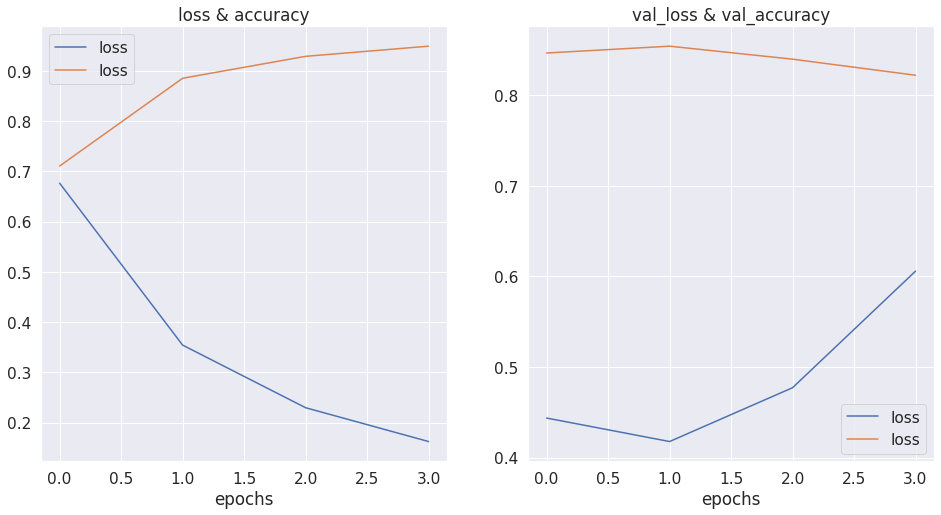

In [72]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

_, axis = plt.subplots(1,2, figsize=(16,8))
axis[0].plot(range(EPOCHS), loss, label='loss')
axis[0].plot(range(EPOCHS), acc, label='loss')
axis[1].plot(range(EPOCHS), val_loss, label='loss')
axis[1].plot(range(EPOCHS), val_acc, label='loss')
axis[0].legend()
axis[1].legend()
axis[0].set_title('loss & accuracy')
axis[0].set_xlabel('epochs')

axis[1].set_title('val_loss & val_accuracy')
axis[1].set_xlabel('epochs')

plt.show()

In [73]:
X_test = tokenizer.texts_to_sequences(test_df['newTweet'])
X_test = pad_sequences(X_test, max_len, padding='post')



In [77]:
y_test = test_df['Sentiment'].apply(pretrain)


y_pred = model.predict(X_test)

print(y_pred)

[[0.3626078  0.8673909  0.32472566]
 [0.9968148  0.05987626 0.06558181]
 [0.99983287 0.03986141 0.01151077]
 ...
 [0.02888288 0.05518988 0.99549305]
 [0.08552051 0.9986247  0.05552428]
 [0.9999536  0.01819785 0.00732785]]


In [78]:
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

[1 0 0 ... 2 1 0]


In [79]:
print(y_test.shape)

(3798,)


In [80]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8033175355450237
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1546
           1       0.85      0.74      0.79      1633
           2       0.84      0.73      0.78       619

    accuracy                           0.80      3798
   macro avg       0.82      0.79      0.80      3798
weighted avg       0.81      0.80      0.80      3798



Text(76.8, 0.5, 'True Value')

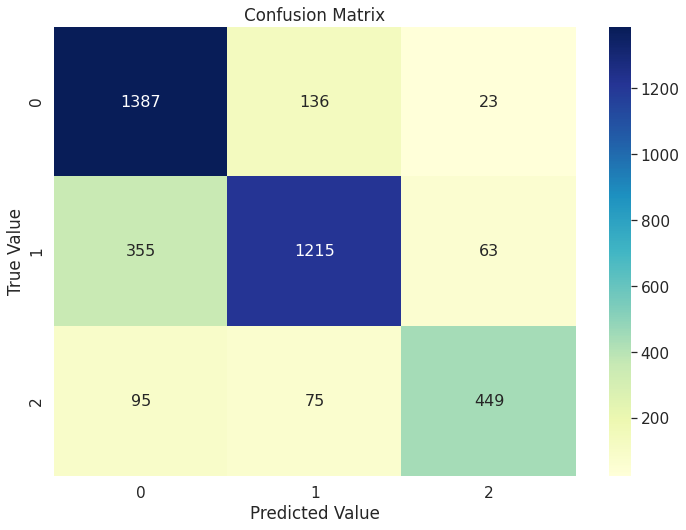

In [81]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

###The test data has a good accuracy Precision and Recall having significantly improved for neutral tweets for RNN better than the other models and we also achieved a significantly higher accuracy than the other models. We can see correctly classified labels in the confusion matrix. we can also try other formats of RNN like lstm or bi-directional lstm. which can also improve the accuracy of the model.
 